# The purpose of this notebook is to analyze and make predictions using chest compression data

In [19]:
import pandas as pd
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from scipy import signal

In [2]:
# Load data
df_mat = pd.read_csv('data/air_mat_comp_600.csv')
print(df_mat.shape)
dfg_pil = pd.read_csv('data/Pillow-CPR.csv')
print(dfg_pil.shape)
dfg_ted = pd.read_csv('data/TeddyBear-CPR.csv')
print(dfg_ted.shape)
dfr_pil = pd.read_csv('data/pillow_reed.csv')
print(dfr_pil.shape)
dfr_ted = pd.read_csv('data/teddy_reed.csv')
print(dfr_ted.shape)

(57074, 5)
(14269, 5)
(9704, 5)
(14124, 5)
(14160, 5)


## Absolute truth: Number of compressions per data set
- Mattress ------> 600 (30 per set)
- Pillow George -> 150 (30 per set)
- Pillow Reed ---> 150?
- Teddy George --> 150 (30 per set)
- Teddy Reed ----> 150?

### Add labels to each of the dataframes to indicate their compression object

In [3]:
df_mat['object'] = "mattress"
dfg_pil['object'] = "pillow_george"
dfg_ted['object'] = "teddy_george"
dfr_pil['object'] = "pillow_reed"
dfr_ted['object'] = "teddy_reed"

In [4]:
# Rename columns in df_mat
df_mat = df_mat.rename(columns={'Linear Acceleration x (m/s^2)': 'Acceleration x (m/s^2)',\
                       'Linear Acceleration y (m/s^2)': 'Acceleration y (m/s^2)',\
                       'Linear Acceleration z (m/s^2)':'Acceleration z (m/s^2)'}) 

### Create time delta column

In [5]:
def time_delta(data):
    data['prev_time'] = data['Time (s)'].shift(1)
    data['time_delta'] = data['Time (s)'] - data['prev_time']
    return data

In [6]:
df_mat = time_delta(df_mat)
dfg_pil = time_delta(dfg_pil)
dfg_ted = time_delta(dfg_ted)
dfr_pil = time_delta(dfr_pil)
dfr_ted = time_delta(dfr_ted)

In [7]:
dfg_pil.head()

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Absolute acceleration (m/s^2),object,prev_time,time_delta
0,0.001063,-1.021027,0.250579,9.786649,9.842956,pillow_george,NaN,NaN
1,0.011133,-0.998424,0.197140,9.809102,9.861754,pillow_george,0.001063,0.010070
2,0.021203,-0.964594,0.187859,9.795929,9.845098,pillow_george,0.011133,0.010070
3,0.031274,-0.955912,0.233215,9.776769,9.826158,pillow_george,0.021203,0.010071
4,0.041344,-0.952769,0.271984,9.744736,9.794979,pillow_george,0.031274,0.010070


### Stack all dataframes

In [8]:
print("expected row count:",df_mat.shape[0] + 
                            dfg_pil.shape[0] +
                            dfg_ted.shape[0] +
                            dfr_pil.shape[0] +
                            dfr_ted.shape[0])
df = pd.concat([df_mat,dfg_pil,dfg_ted,dfr_pil,dfr_ted], ignore_index=True,sort=False)
print('actual row count  :',df.shape[0])

expected row count: 109331
actual row count  : 109331


In [9]:
dfr_ted.tail()

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Absolute acceleration (m/s^2),object,prev_time,time_delta
14155,142.587235,-3.286566,7.068601,7.770791,11.006899,teddy_reed,142.577160,0.010075
14156,142.597310,-3.248994,6.948550,7.612121,10.806604,teddy_reed,142.587235,0.010075
14157,142.607385,-2.510729,6.655161,7.087162,10.041055,teddy_reed,142.597310,0.010075
14158,142.617460,-1.505719,6.329588,5.815706,8.726586,teddy_reed,142.607385,0.010075
14159,142.627535,-2.702181,7.017108,5.316644,9.209141,teddy_reed,142.617460,0.010075


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109331 entries, 0 to 109330
Data columns (total 8 columns):
Time (s)                         109331 non-null float64
Acceleration x (m/s^2)           109331 non-null float64
Acceleration y (m/s^2)           109331 non-null float64
Acceleration z (m/s^2)           109331 non-null float64
Absolute acceleration (m/s^2)    109331 non-null float64
object                           109331 non-null object
prev_time                        109326 non-null float64
time_delta                       109326 non-null float64
dtypes: float64(7), object(1)
memory usage: 6.7+ MB


### Plot data:
- Are peaks easy to visualize?

In [11]:
df.columns

Index(['Time (s)', 'Acceleration x (m/s^2)', 'Acceleration y (m/s^2)',
       'Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)', 'object',
       'prev_time', 'time_delta'],
      dtype='object')

In [12]:
# df[df['object'] == 'mattress'].plot(x='Time (s)', y=['Acceleration x (m/s^2)', 
#                                                      'Acceleration y (m/s^2)',
#                                                      'Acceleration z (m/s^2)', 
#                                                      'Absolute acceleration (m/s^2)'], kind="bar", figsize=(9, 8))

Text(0.5, 1.0, 'Mattress Compressions over Time')

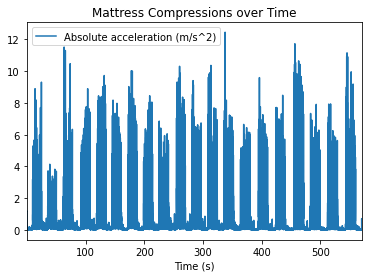

In [13]:
# Mattress
df[df['object'] == 'mattress'].plot( 'Time (s)' , 'Absolute acceleration (m/s^2)')
#df[df['object'] == 'mattress'].plot( 'Time (s)' , 'Acceleration x (m/s^2)')
#df[df['object'] == 'mattress'].plot( 'Time (s)' , 'Acceleration y (m/s^2)')
#df[df['object'] == 'mattress'].plot( 'Time (s)' , 'Acceleration z (m/s^2)')
plt.title("Mattress Compressions over Time")

Text(0.5, 1.0, 'Pillow George Compressions over Time')

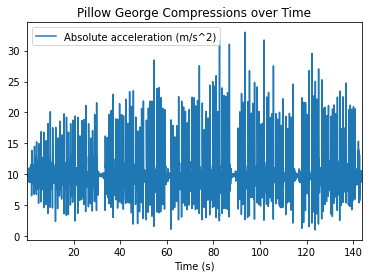

In [14]:
# George pillow
df[df['object'] == 'pillow_george'].plot( 'Time (s)' , 'Absolute acceleration (m/s^2)')
plt.title("Pillow George Compressions over Time")

Text(0.5, 1.0, 'Teddy George Compressions over Time')

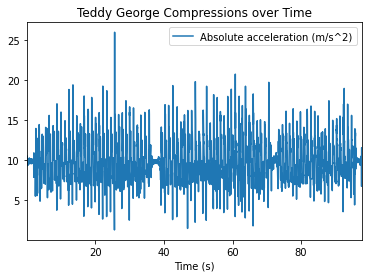

In [15]:
# George teddy
df[df['object'] == 'teddy_george'].plot( 'Time (s)' , 'Absolute acceleration (m/s^2)')
plt.title("Teddy George Compressions over Time")

Text(0.5, 1.0, 'Pillow Reed Compressions over Time')

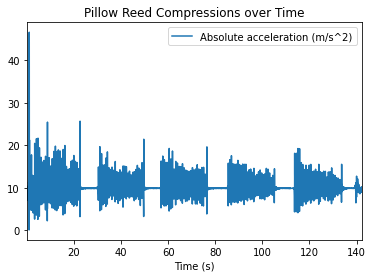

In [16]:
# Reed pillow
df[df['object'] == 'pillow_reed'].plot( 'Time (s)' , 'Absolute acceleration (m/s^2)')
plt.title("Pillow Reed Compressions over Time")

Text(0.5, 1.0, 'Teddy Reed Compressions over Time')

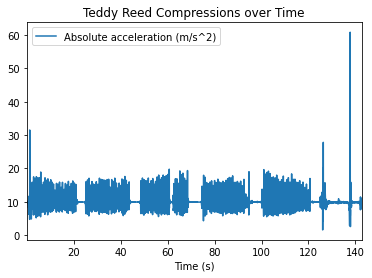

In [17]:
# Reed teddy
df[df['object'] == 'teddy_reed'].plot( 'Time (s)' , 'Absolute acceleration (m/s^2)')
plt.title("Teddy Reed Compressions over Time")

## Notes: 
- All compression data seems to be well spaced
- George Teddy data seems to be 90 compressions
    - Confirm with George

### Create the following:
- Half second increment column
  - Ascneding in value
- Rolling std
  - std across half second increment blocks

In [26]:
df.head()

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Absolute acceleration (m/s^2),object,prev_time,time_delta
0,0.016569,-0.079748,-0.011341,1.189440,1.192164,mattress,NaN,NaN
1,0.026562,-0.009065,-0.054324,1.198593,1.199857,mattress,0.016569,0.009993
2,0.036555,0.080083,-0.027440,0.352316,0.362343,mattress,0.026562,0.009993
3,0.046548,0.092367,-0.035558,-0.328451,0.343039,mattress,0.036555,0.009993
4,0.056541,0.074421,-0.023063,-0.515041,0.520901,mattress,0.046548,0.009993


In [25]:
# Roughly how many rows in .1 seconds?
df['time_delta'].head(11).sum()

0.09992899998

In [37]:
# A compression may occur in a fraction of a second
# Take the rolling std for every ten rows
df['rolling_stdev'] = df['Absolute acceleration (m/s^2)'].rolling(10).std()

In [41]:
df.head(20)

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Absolute acceleration (m/s^2),object,prev_time,time_delta,rolling_stdev
0,0.016569,-0.079748,-0.011341,1.189440,1.192164,mattress,NaN,NaN,NaN
1,0.026562,-0.009065,-0.054324,1.198593,1.199857,mattress,0.016569,0.009993,NaN
2,0.036555,0.080083,-0.027440,0.352316,0.362343,mattress,0.026562,0.009993,NaN
3,0.046548,0.092367,-0.035558,-0.328451,0.343039,mattress,0.036555,0.009993,NaN
4,0.056541,0.074421,-0.023063,-0.515041,0.520901,mattress,0.046548,0.009993,NaN
5,0.066534,0.045828,0.082534,-0.551452,0.559474,mattress,0.056541,0.009993,NaN
6,0.076527,0.007005,0.124853,-0.724355,0.735070,mattress,0.066534,0.009993,NaN
7,0.086520,0.029431,-0.075169,-0.886498,0.890165,mattress,0.076527,0.009993,NaN
8,0.096512,0.057343,0.082388,-0.567792,0.576597,mattress,0.086520,0.009992,NaN
9,0.106505,0.065172,0.088598,0.157557,0.192149,mattress,0.096512,0.009993,0.346015


Text(0.5, 1.0, 'Rolling Standard Dev over Time')

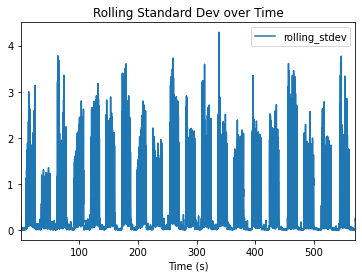

In [38]:
df[df['object'] == 'mattress'].plot( 'Time (s)' , 'rolling_stdev')
plt.title("Mattress: Rolling Standard Dev over Time")

Text(0.5, 1.0, 'Pillow George: Rolling Standard Dev over Time')

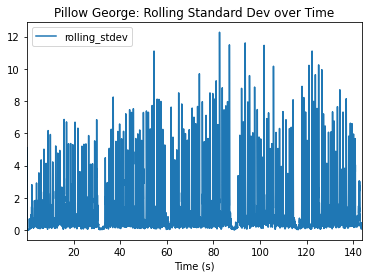

In [43]:
df[df['object'] == 'pillow_george'].plot( 'Time (s)' , 'rolling_stdev')
plt.title("Pillow George: Rolling Standard Dev over Time")